<a href="https://colab.research.google.com/github/SAIcomsci/Malaria_Detection_DeepLearning/blob/main/FineTunedVGG19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Importing necessary libraries

In [ ]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
import glob
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten,Conv2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model

In [ ]:
train_dir = "/content/drive/MyDrive/Colab Notebooks/Malaria detection/MalariaDataset/cell_images/train"
test_dir = "/content/drive/MyDrive/Colab Notebooks/Malaria detection/MalariaDataset/cell_images/test"
val_dir = "/content/drive/MyDrive/Colab Notebooks/Malaria detection/MalariaDataset/cell_images/val"

In [ ]:
img_Datagen = ImageDataGenerator(
        rescale = 1/255,
        shear_range=10,
        zoom_range=0.3,
        horizontal_flip=True,
        vertical_flip=True,
        brightness_range=[0.5,1.0],
        width_shift_range = 0.2,
        rotation_range=20,
        fill_mode = 'nearest'
)
val_Datagen = ImageDataGenerator(
        rescale = 1/255
)

In [ ]:
train = img_Datagen.flow_from_directory(train_dir,
                                       batch_size=64,
                                       class_mode='categorical',
                                      target_size=(224,224,)
                                       )

validation = val_Datagen.flow_from_directory(val_dir,
                                              batch_size=32,
                                              class_mode='categorical',
                                             target_size=(224,224,)
                                            )

test = val_Datagen.flow_from_directory(test_dir,
                                       batch_size=64,
                                       class_mode='categorical',
                                        target_size=(224,224,)
                                      )

Found 17360 images belonging to 2 classes.
Found 1928 images belonging to 2 classes.
Found 8270 images belonging to 2 classes.


In [ ]:
vgg19_model = tf.keras.applications.VGG19(
    weights='imagenet',
    include_top = False,
    input_shape = (224,224,3)
)

vgg19_model.trainable = True
fine_tune_at = 17 

# Freeze all the layers before the `fine_tune_at` layer
for layer in vgg19_model.layers[:fine_tune_at]:
  layer.trainable = False


x = vgg19_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x=tf.keras.layers.Dense(512,activation='relu')(x)
# output layer
predictions = tf.keras.layers.Dense(2,activation='sigmoid')(x)
#MATRICS=[
#         tf.keras.metrics.Accuracy(nmae='accuracy'),
#         tf.keras.matrics.Precision(name='precision'),
#        tf.keras.matrics.Recall(name='recall')
#]
model = tf.keras.Model(inputs=vgg19_model.input, outputs=predictions)
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

80150528/80134624 [==============================] - 0s 0us/step


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
print("Number of layers in the base model: ", len(vgg19_model.layers))

Number of layers in the base model:  22


In [ ]:
print("No of layers to be trained :",len(model.trainable_variables))

No of layers to be trained : 12


In [ ]:

total_epochs=25
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=10)
lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',patience=8)

history_fine =model.fit(train,epochs=total_epochs, 
                    validation_data=validation,
                    #steps_per_epoch=100,
                    callbacks=[early_stopping,lr],
                    batch_size=64
                    )

model.save("Fine_tuned_VGG19.h5")




Epoch 1/25
272/272 [==============================] - 5030s 18s/step - loss: 0.7030 - accuracy: 0.4955 - val_loss: 0.6931 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/25
272/272 [==============================] - 289s 1s/step - loss: 0.6933 - accuracy: 0.4926 - val_loss: 0.6931 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/25
272/272 [==============================] - 288s 1s/step - loss: 0.6932 - accuracy: 0.4993 - val_loss: 0.6932 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/25
272/272 [==============================] - 290s 1s/step - loss: 0.6932 - accuracy: 0.4965 - val_loss: 0.6932 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 5/25
272/272 [==============================] - 289s 1s/step - loss: 0.6932 - accuracy: 0.4993 - val_loss: 0.6932 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 6/25
272/272 [==============================] - 289s 1s/step - loss: 0.6932 - accuracy: 0.4979 - val_loss: 0.6932 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 7/25
272/272 [==============================] - 289s 1s/

In [ ]:
model=load_model('Fine_tuned_VGG19.h5')

In [ ]:
# Evaluating the model on train and test
score = model.evaluate(train)

print("Train Loss: ", score[0])
print("Train Accuracy: ", score[1])

272/272 [==============================] - 270s 991ms/step - loss: 0.1541 - accuracy: 0.9467
Train Loss:  0.1541285663843155
Train Accuracy:  0.9467166066169739


In [ ]:
# Test data
score = model.evaluate(test)

print("Test Loss: ", score[0])
print("Test Accuracy: ", score[1])

130/130 [==============================] - 1961s 15s/step - loss: 0.1172 - accuracy: 0.9608
Test Loss:  0.11722618341445923
Test Accuracy:  0.9608222246170044


Text(0.5, 1.0, 'Accuracy Evolution')

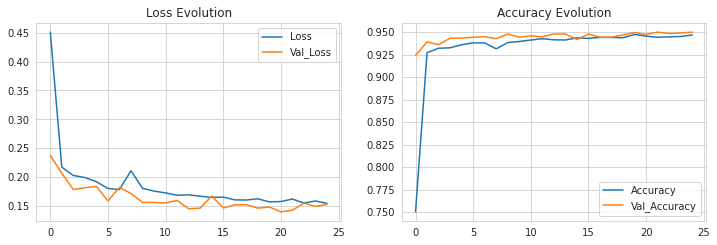

In [ ]:
plt.figure(figsize=(12, 8))
plt.title('EVALUATION OF Fine_tunedVGG19')

plt.subplot(2, 2, 1)
plt.plot(history_fine.history['loss'], label='Loss')
plt.plot(history_fine.history['val_loss'], label='Val_Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(2, 2, 2)
plt.plot(history_fine.history['accuracy'], label='Accuracy')
plt.plot(history_fine.history['val_accuracy'], label='Val_Accuracy')
plt.legend()
plt.title('Accuracy Evolution')